# Семинар 12. VAE. 

Импорт необходимых библиотек :)

In [2]:
import itertools
import numpy as np
import torch

from tqdm import tqdm
from torch import nn
from torch import optim
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torch.nn import functional as F

from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

# 12.1 Теория.

**VAE** одна из любимых тем любого интервьюера (: Если вас спросят, где в индустрии работает **VAE**, то ответ "на собеседованиях" точно не будет неправильным!

Поэтому его небольшую теорию нужно понимать отлично (:

### ELBO

Задача максимизации правдоподобия:

$$
    \log p(\mathbf{X}| \mathbf{\theta})  \to \max_{\mathbf{\theta}}
$$


Введение скрытой перменной:

$$
\begin{align*}
    \log p(\mathbf{X}| \mathbf{\theta}) &= \log \frac{p(\mathbf{X, Z}| \mathbf{\theta})}{p(\mathbf{Z}| \mathbf{X, \theta})} = 
     \int q(\mathbf{Z}) \log\frac{ p(\mathbf{X, Z}| \mathbf{\theta})}{p(\mathbf{Z}| \mathbf{X, \theta})} d\mathbf{Z} = \\
    &= \int q(\mathbf{Z}) \log\frac{ p(\mathbf{X, Z}| \mathbf{\theta})  q(\mathbf{Z})}{p(\mathbf{Z}| \mathbf{X, \theta})  q(\mathbf{Z})} d\mathbf{Z} = \\
    &= \int q(\mathbf{Z}) \log \frac{ p(\mathbf{X, Z}| \mathbf{\theta})}{q(\mathbf{Z})} d\mathbf{Z} + \int  q(\mathbf{Z})\log \frac{q(\mathbf{Z})}{p(\mathbf{Z}| \mathbf{X, \theta})}  d\mathbf{Z} =\\
    &= \mathcal{L}(q, \mathbf{\theta}) + KL(q(\mathbf{Z}) || p(\mathbf{Z}| \mathbf{X, \theta}))
\end{align*}
$$


Где $q$ - вариационное распределение, $\mathcal{L}$ - ELBO, $KL( * || *)$ - дивиргенция Кульбака-Лейблера

### EM-алгоритм

<img src="images/EM_algorithm.png" width=1000 height=1000 />

Задача макcимизации ELBO
$$
    \mathcal{L}(q, \mathbf{\theta})  \to \max_{q, \mathbf{\theta}}
$$


E-шаг
$$
    q(\mathbf{Z})_{n+1} = p(\mathbf{Z}|\mathbf{X}, \mathbf{\theta}_n)
$$

M-шаг
$$
    \begin{align*}
         \mathcal{L}(q, \mathbf{\theta}) &= \int q(\mathbf{Z}) \log \frac{p(\mathbf{X, Z}| \mathbf{\theta})}{q(\mathbf{Z})} d\mathbf{Z} = \\
          &= \int q(\mathbf{Z}) \log p(\mathbf{X, Z}| \mathbf{\theta}) d\mathbf{Z} - \int q(\mathbf{Z}) \log{q(\mathbf{Z})} d\mathbf{Z}\\
          \mathbf{\theta}_{n+1} &= \text{arg} \max_{\mathbf{\theta}} \mathcal{L}(q_{n+1}, \mathbf{\theta}) = \text{arg} \max_{\mathbf{\theta}} \int q(\mathbf{Z}) \log p(\mathbf{X, Z}| \mathbf{\theta}) d\mathbf{Z} 
    \end{align*}
$$

<!-- ### Вариационный ЕМ-алгоритм

Факторизаця вариационного распределения
$$
    q( \mathbf{Z} ) = \prod \limits_{i=1}^{n} q_i(Z_i)
$$


ELBO

$$
\begin{align*}
    \mathcal{L}(q) &= \int q(\mathbf{Z}) \log \frac{ p(\mathbf{X, Z})}{q(\mathbf{Z})} d\mathbf{Z}  = \int \prod \limits_{i=1}^{n} q_i(Z_i)  \log \frac{ p(\mathbf{X, Z})}{\prod \limits_{i=1}^{n} q_i(Z_i)} \prod \limits_{i=1}^{n} dZ_i = \\
    &= \int q_j \left[\int \log p(\mathbf{X, Z}) \prod \limits_{i \neq j} q_i dZ_i \right] dZ_j - \int q_j \log q_j dZ_j + \text{const}(q_j)
\end{align*}
$$

Обозначения

$$
\begin{align*}
\log \hat{p}(\mathbf{X}, Z_j) &= \mathbb{E}_{i \neq j} \log p(\mathbf{X, Z}) + \text{const}(q_j) \\
\mathbb{E}_{i \neq j} \log p(\mathbf{X, Z}) &= \int \log p(\mathbf{X, Z}) \prod \limits_{i \neq j} q_i dZ_i
\end{align*}
$$

Задача максимизации ELBO

$$
\begin{align*}
    \mathcal{L}(q) &= \int q_j(Z_j) \log \hat{p}(\mathbf{X}, Z_j) dZ_j - \int q_j(Z_j) \log q_j(Z_j) dZ_j + \text{const}(q_j) = \\
    &= KL(q_j(Z_j)||\hat{p}(\mathbf{X}, Z_j)) + \text{const}(q_j) \to \max_{q_j}
\end{align*}
$$

Решение

$$
\begin{align*}
q_j(Z_j) &= \hat{p}(\mathbf{X}, Z_j) \\
\log q_j(Z_j) &= \mathbb{E}_{i \neq j} \log p(\mathbf{X}, \mathbf{Z}) + \text{const}
\end{align*}
$$ -->

### VAE

Представим $\mathcal L $ в виде:
    \begin{align*}
         \mathcal{L}(q, \mathbf{\theta}) &= \int q(\mathbf{Z}) \log \frac{p(\mathbf{X, Z}| \mathbf{\theta})}{q(\mathbf{Z})} d\mathbf{Z} = \\
         &= \int q(\mathbf{Z}) \log \frac{p(\mathbf{X, Z}| \mathbf{\theta}) p(\mathbf{Z})}{q(\mathbf{Z})p(\mathbf{Z})} d\mathbf{Z} = \\
          &= \int q(\mathbf{Z}) \log p(\mathbf{X| Z},  \mathbf{\theta}) d\mathbf{Z} - KL(q(\mathbf{Z})|p(\mathbf{Z})) 
    \end{align*}


Далее мы будем параметрически приближать вариационное распределение максимизирую ELBO. В данном случае вариационное распределение будет кодироваться нейросетью-энкодером. То етсь, $q(\mathbf{z})$ из некоторого параметрического семейства: $q(\mathbf{z}|\mathbf{x}, \phi)$ заданного энкодером. Оптимизация параметров $\phi$ будет некотором аналогом E-шага классического EM-алгоритма. Декодер будет моделировать распределение $p(\mathbf{x}|\mathbf{z}^*, \theta)$, где $\mathbf{z}^* \sim q(\mathbf{z}|\mathbf{x}, \phi)$.

Понятно, что для всего этого никакая сходимость не гарантируется и зазор между оценками ELBO и максимизацией правдоподобия может быть большим. 

M-шаг:

$$
\theta_k = \theta_{k-1} + \nu \nabla _\theta \mathcal{L}(\phi, \theta)
$$

$$
\nabla_\theta \mathcal{L}(\phi, \theta) = \sum \limits_{i=1}^n \int q(\mathbf{z}_i|\mathbf{x}_i, \phi) \nabla_ \theta \log p(\mathbf{x}_i| \mathbf{z}_i, \theta) d\mathbf{z}_i =
$$

$$
= n \nabla_ \theta \log p(\mathbf{x}_i| \mathbf{z}^*_i, \theta) d\mathbf{z}_i, \; \mathbf{z}_i^* \sim q(\mathbf{z}_i|\mathbf{x}_i, \phi)
$$

Е-шаг:
$$
\phi_k = \phi_{k-1} + \nu \nabla _\phi \mathcal{L}(\phi, \theta)
$$

$$
\nabla_\phi \mathcal{L}(\phi, \theta) = \int \nabla_{\phi} q(\mathbf{Z}|\mathbf{X}, \phi) \log p(\mathbf{X}| \mathbf{Z}, \theta) d\mathbf{Z} - \nabla_{\phi} KL = 
$$

$$
= \int q(\mathbf{Z}|\mathbf{X}, \phi) \nabla_{\phi} \log q(\mathbf{Z}|\mathbf{X}, \phi) \log q(\mathbf{Z}|\mathbf{X}, \phi) \log p(\mathbf{X}| \mathbf{Z}, \theta) d\mathbf{Z} - \nabla_{\phi} KL
$$

$$
\approx n \nabla_\phi \log p(\mathbf{x}_i|g(\mathbf{x}_i, \epsilon^*, \phi), \theta) - \nabla_\phi KL
$$

Здесь последовательно применены 2  приема, описанные ниже.

Log-derivative trick:

$$
\nabla_\psi q(\eta|\psi) = q(\eta|\psi) \nabla_\psi \log q(\eta|\psi)
$$

Для вычисления интеграла также используется оценка Монте-Карло.

### Reparametrization Trick

$$
  f(\psi) = \int q(\eta| \psi) h(\eta) d\eta
$$

Пусть: $\eta = g(\psi, \epsilon)$, где $g$ - неслучайная функция и $\epsilon$ имеет плотность $r(\epsilon)$.

Тогда:

$$
\nabla_\psi f(\psi) = \nabla_\psi \int r(\epsilon) h(g(\psi, \epsilon))d\psi \approx \nabla_\psi h(g(\psi, \epsilon^*))
$$

Для нормального распределения:

$$
q(\eta|\psi) = N(\eta|\mu, \sigma^2), r(\epsilon) = N(\epsilon|0, 1), \eta = \sigma*\epsilon + \mu
$$

### Параметры VAE:

Вариационное распределение:
$$
q(z|x, \phi) = N(\mu(x), \Sigma(x)) ~\sim \frac{1}{(2 \pi)^\frac{n}{2} (det \Sigma ^ \frac{1}{2}) } \exp  (- \frac{1}{2} (z - \mu(x))^\top \Sigma (z - \mu))
$$

Априорное распределение: 
$$
p(Z) = N(0, I) 
$$

В таком случае удается найти аналитическое решение для KL.

$$
KL(p(Z)| q(Z)) = \int p(Z) \log \frac{p(Z)}{q(Z)} dZ = \dots = \\
= - \frac{1}{2} \sum \limits_{i=1}^n (1 + \log \sigma_i(x) - \mu_i(x)^2 - \sigma_i)
$$


## **12.2** Загрузка данных

В представление не нуждается, гроза всех теоретических методов, **MNIST**

len(train_data) :  60000
len(val_data) :  10000
image.shape :  torch.Size([1, 28, 28])
label :  5


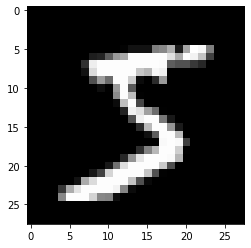

In [3]:
data_transform = Compose([ToTensor()])# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 

train_data = MNIST(download=True, root="/tmp/mnist/", transform=data_transform, train=True)
val_data   = MNIST(download=True, root="/tmp/mnist/", transform=data_transform, train=False)

image = train_data[0][0]
label = train_data[0][1]

print ('len(train_data) : ', len(train_data))
print ('len(val_data) : ', len(val_data))
print ('image.shape : ', image.shape)
print ('label : ', label)

img = plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.show()

In [4]:
train_loader = DataLoader(train_data, batch_size=32)
val_loader = DataLoader(train_data, batch_size=32)

x, y = next(iter(train_loader))
print ('x.shape : ', x.shape)
print ('y.shape : ', y.shape)

x.shape :  torch.Size([32, 1, 28, 28])
y.shape :  torch.Size([32])


## 12.3 VAE Model

![](https://drive.google.com/uc?export=view&id=1cJnI3nC0__k2Xft3DHfNbYCjYZAo-Q9s)

In [5]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), hidden_size=400, latent_space_size=20):
        super(VAE, self).__init__()
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 
        self.shape = input_shape
        feature_size = np.prod(input_shape)
        self.fc1  = nn.Linear(feature_size, hidden_size      )
        self.fc21 = nn.Linear(hidden_size , latent_space_size)
        self.fc22 = nn.Linear(hidden_size , latent_space_size)
        
        self.fc3 = nn.Linear(latent_space_size, hidden_size )
        self.fc4 = nn.Linear(hidden_size      , feature_size)
          

    def encode(self, x):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
        x = x.view(x.shape[0], -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x.view(-1, *self.shape), mu, logvar
    
    def generate(self, z=None, num_img=1, device="cuda"):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
        if z is None:
            z = torch.randn((num_img, 20)).to(device)
        else:
            num_img = z.shape[0]
        x = self.decode(z)
        return x.view(num_img, *self.shape)
    
    def get_var_dist(self, x):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
        x = x.view(x.shape[0], -1)
        mu, logvar = self.encode(x)
        return mu

In [6]:
class KLD_loss(nn.Module):
    def forward(self, mu, logvar):
        # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 
        return -0.5 *torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


In [7]:
class EmptyContext:
    def __enter__(self):
        pass
    def __exit__(self, type, value, traceback):
        pass

def perform_epoch(model, loader, bce, kld, optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    bce_list = []
    kld_list = []
    with EmptyContext() if is_train else torch.no_grad():
        for batch_train, batch_answers in loader:
            batch_train = batch_train.to(device)
            batch_answers = batch_answers.to(device)        
            model_answers, mu, logvar = model(batch_train)
            
            bs= batch_train.shape[0]
            
            bce_loss = bce(model_answers.view(bs, -1), batch_train.view(bs, -1) )
            kld_loss = kld(mu, logvar)
            
            new_loss = bce_loss + kld_loss
            
            bce_list.append(float(bce_loss))
            kld_list.append(float(kld_loss))
            
            # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 
            
            if is_train:
                optimizer.zero_grad()
                new_loss.backward()
                optimizer.step() 
    return bce_list, kld_list

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-3
decay_rate =0.9
num_epoches = 1

In [12]:
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
model     = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
kld_loss = KLD_loss()
bce_loss = nn.BCELoss(reduction='sum')

In [13]:
for epoch in range(num_epoches):
    bce, kld = perform_epoch(model, train_loader, bce_loss, kld_loss, optimizer, device)
    print(f"Epoch - {epoch+1}: BCE - {np.mean(bce)}, KLD - {np.mean(kld)}")


Epoch - 1: BCE - 3853.7817971354166, KLD - 611.3659515652975


## 12.4 Визуализация генерированных данных

Теперь попробуем генерировать новые данные из латентных векторов.

In [15]:
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
imgs = model.generate(num_img=25).cpu().detach().numpy()

Теперь мы хотим отобразить изображения плиткой 5 на 5. 

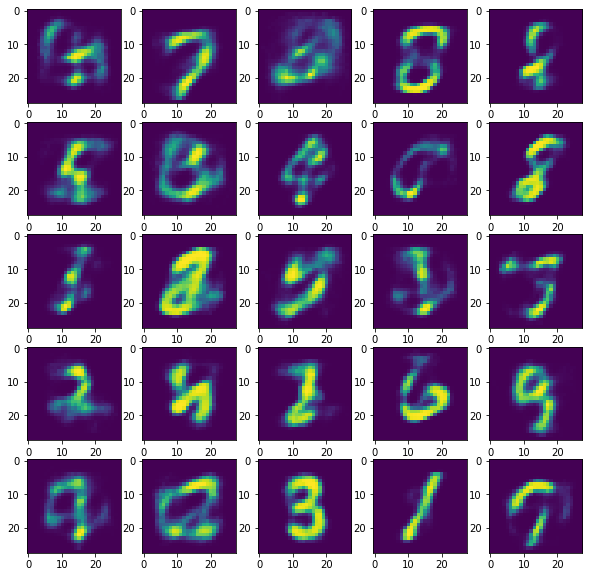

In [16]:
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
w, h = 5, 5
fig = plt.figure(figsize = (10,10))
for i, img in enumerate(imgs):
    fig.add_subplot(h,w, i+1)
    plt.imshow(img[0])
plt.show()

Видим, что все похоже на цифры (:

# 12.5 Пространство цифр

Отобразим вектора $\mu$ в двумерное пространство, убедимся, что данные кластеризуются в этом пространстве!

In [17]:
from sklearn.manifold import TSNE

In [19]:
mus    = []
labels = []

for x, y in val_loader:
    # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
    with torch.no_grad():
        x = x.to(device)
        mu = model.get_var_dist(x)
        mu = mu.cpu().detach().numpy()
        mus.append(mu)
        labels.append(y.numpy())

mus = np.concatenate(mus)
labels = np.concatenate(labels)

In [20]:
 # ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯

mus_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(mus)

In [21]:
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS.values()

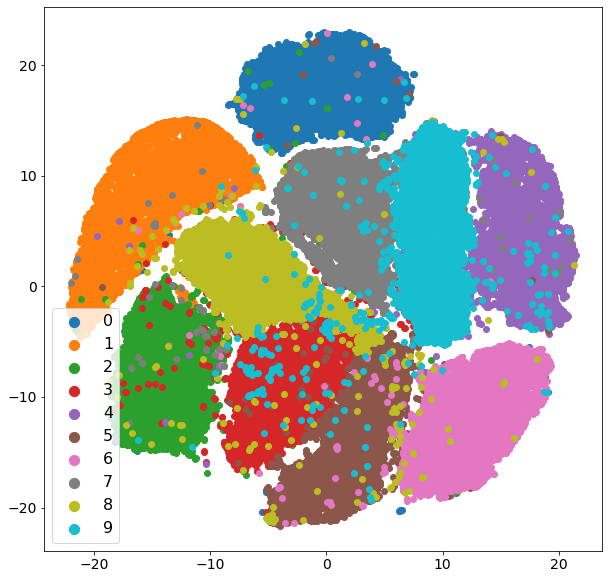

In [22]:
plt.figure(figsize=(10, 10))
scatters = {}
for l, c in zip(set(labels), colors):
    x = mus_2d[:, 0][labels == l]
    y = mus_2d[:, 1][labels == l]
    scatters[c] = plt.scatter(x, y, c=c)
plt.legend(tuple(scatters.values()), 
          tuple(set(labels)), 
          fontsize=16, markerscale=1.7, loc='best', ncol=1)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.show()

Видим, что цифры образуют кластеры, соответствующие их значениям. 

# 12.5 Между кластерами

Последный эксперимент будет посвящен изучению того, как меняется сгенерированное изображение на прямой между центройдами двух кластеров. 

In [29]:
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 
mus_1 = np.mean(mus[labels==1], axis = 0)
mus_6 = np.mean(mus[labels==6], axis = 0)


In [30]:
ts = np.linspace(0, 1, 25)

In [35]:
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯
new_z = []
for t in ts:
    new_z.append(torch.from_numpy(t*mus_1 + (1-t)*mus_6).to(device))
new_z = torch.stack(new_z)

In [36]:
# ¯\_(ツ)_/¯ YOUR CODE HERE ¯\_(ツ)_/¯ 
new_z.shape

torch.Size([25, 20])

In [37]:
imgs = model.generate(z=new_z).cpu().detach().numpy()

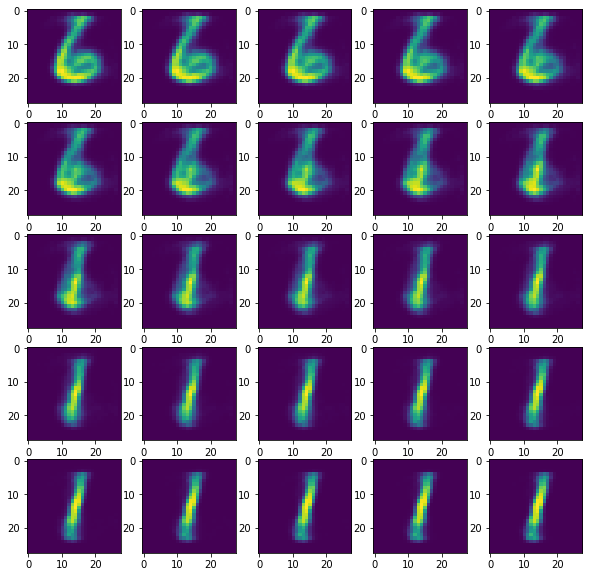

In [38]:
w=5
h=5
fig=plt.figure(figsize=(10, 10))
for i, img in enumerate(imgs):
    fig.add_subplot(h,w, i+1)
    plt.imshow(img[0])
plt.show()

Видим, что все получается красиво и интерпретируемо (:

## 12.6 Итог

Сегодня мы познакомились с вариационным автокодировщиком (: Изучили его теорию и реализовали на практике. Убедились, что VAE - это интерпретируемая генеративная модель. 

Для тех, кто хочет больше математики и теории, смотрите вот этот [курс](https://http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D0%BE%D1%80%D0%BE%D0%B6%D0%B4%D0%B0%D1%8E%D1%89%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%28%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D0%B8_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0%2C_%D0%A0.%D0%92._%D0%98%D1%81%D0%B0%D1%87%D0%B5%D0%BD%D0%BA%D0%BE%2C_%D0%92.%D0%92._%D0%A1%D1%82%D1%80%D0%B8%D0%B6%D0%BE%D0%B2%29/%D0%93%D1%80%D1%83%D0%BF%D0%BF%D0%B0_674%2C_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2020).